In [1]:
import numpy as np
import os, sys
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime as DT
import matplotlib.dates as mdates

import plot_water_table2D

import importlib as imp
print (plot_water_table2D.__file__)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
import parse_ats
print (parse_ats.__file__)

import get_transect_data

/Users/ajc/Core/codes/simulator/repos/amanzi/src/physics/ats/tools/utils/plot_water_table2D.py
/Users/ajc/Core/codes/simulator/repos/amanzi/src/physics/ats/tools/utils/parse_ats.py


In [2]:
path = "/Users/ajc/Core/simulations/hillslope/rain_advection/SIM_06/"

In [35]:
#based on the amount of moisture, your soil takes more/less energy to change temperature as heat 
#capacity gets higher/lower as a response to moisture, right?
#I calculated effective bulk heat capacity based on the respective fractions of
#each substance (water, ice, air, rock), maybe that's exactly how ATS is doing it?
#phi = 0.5 #porosity

hc_w = 76 #[J mol^-1 K^-1]
hc_i= 37
hc_s = 620
hc_g = 28
def get_heat_capacity(sw, si, sg, phi):
    wc = phi * sw
    ic = phi * si
    gc = phi * sg
    HC = wc * hc_w  + ic * hc_i + gc * hc_g + (1-phi)*hc_s
    return HC

In [32]:
Simulations = [['S3_P20_%sA'%(i+1) for i in range(1)], ['S3_P20_%sA'%(i+3) for i in range(1)],
              ['S3_P20_%sB'%(i+1) for i in range(1)], ['S3_P20_%sB'%(i+3) for i in range(1)]]

print (Simulations)

Sim_name = ['S3_P20_1A','S3_P20_3A', 'S3_P20_1B','S3_P20_3B']

varnames = ['saturation_liquid', 'saturation_ice', 'saturation_gas', 'base_porosity']

[['S3_P20_1A'], ['S3_P20_3A'], ['S3_P20_1B'], ['S3_P20_3B']]


In [33]:
def getData(i):
    Data = []
    Time = []
    for s in Simulations[i]:    
        infile = os.path.join(path,s)
        Tim1, Dat1 = get_transect_data.get2DMatrix(infile,varnames=varnames)
        a1 = len(Dat1[0,:,0,0])%365
        a2 = len(Dat1[0,:,0,0]) - a1
        
        Tim = Tim1[:a2]
        Dat = Dat1[:,:a2,:,:]
        Time.append(Tim)
        Data.append(Dat)
    d = dict()
    d['data'] = Data
    d['time'] = Time
    
    return d

In [34]:
from multiprocessing import Pool
num_processors = 4
p=Pool(processes = num_processors)

DataS1, DataS2, DataS3, DataS4 = p.map(getData,[i for i in range(len(Simulations))])

In [36]:
#Data = [DataS1, DataS2, DataS3, DataS4, DataS5, DataS6,DataS7,DataS8]
Data = [DataS1, DataS2, DataS3, DataS4]

In [37]:
np.array(DataS1['data']).shape
#len(DataS1['data'])

(1, 6, 365, 300, 86)

In [91]:
def get_temp_at_depth(dat,x0, x1,z0,z1=-1, yr_cyc=365,domain='entire'):
    #25 * 2cm = 50 cm
    sim_len = len(dat['data'])
    x_pos = x0
    data = []
    times = []
    HillslopeT = dict()
    AvgTemp = [] # np.zeros(cycles)
    for k in range(sim_len):
        data = np.array(dat['data'][k])
        time = dat['time'][k]
        nvar, cycles, xnum, znum = data.shape
     
        zlen = len(data[1,0,0,:])-1
        xlen = len(data[0,0,:,0])-1
       
        for cyc in range(cycles):
            #sum1 = data[nvar-1,cyc,x_pos,zlen-depth_s]
            sw = np.mean(data[2,cyc,:,zlen-z1:zlen-z0])
            #print (zlen-z0,zlen-z1)
            si = np.mean(data[3,cyc,:,zlen-z1:zlen-z0])
            sg = np.mean(data[4,cyc,:,zlen-z1:zlen-z0])
            phi = np.mean(data[5,cyc,:,zlen-z1:zlen-z0])
            hc = get_heat_capacity(sw, si, sg, phi)
            #print (hc,sw, si, sg, phi)
            #break
            AvgTemp.append(hc)
        
        times.append(time)
        #break
    L = len(AvgTemp)%int(yr_cyc)
    times = np.concatenate(times)
    
    HillslopeT['times'] = np.array([t*365 - 365. for t in times])
    HillslopeT_Avg = np.array(AvgTemp)
    
    HillslopeT['temp'] = HillslopeT_Avg
    return HillslopeT



In [92]:
depth1 = [[0,10]] # active layer, 0.5-2 m, 2-3.5m

In [136]:
x0,x1 = 100,5
z0,z1 = 1,25
Data_X = dict()


Names = ['S1', 'S2','S3', 'S4','S5', 'S6','S7', 'S8']

for dat,name in zip(Data,Names):
    #print (name)
    d = get_temp_at_depth(dat,x0,x1,z0,z1,yr_cyc=365,domain='entire')
    Data_X[name + '_temp'] = d['temp']
    Data_X[name +'_time'] = d['times']
    #break

In [137]:
print (Data_X.keys())
#print (Data_X['S1_top_temp'])
outfile='/Users/ajc/Documents/MyPapers/RainWarming/figures/'

dict_keys(['S1_temp', 'S1_time', 'S2_temp', 'S2_time', 'S3_temp', 'S3_time', 'S4_temp', 'S4_time'])


In [141]:
# Three zones : Active layer, shallow permafrost, deep permafrost
#%matplotlib qt

def Plot_HeatCapacity():
    fig, axs = plt.subplots(1,1, figsize=(6,4), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)
    plt.tight_layout()
    #ax = ax.ravel()
    Colors = ['k','r','g','c']
    marks = ['solid', 'dashed', 'dotted']
    X, T1 = [], []
    
    Names = ['S1', 'S2','S3', 'S4','S5', 'S6','S7', 'S8']
    
    for i in range(1):
        S1 = [x for x in Data_X['S1_temp']]
        S2 = [x  for x in Data_X['S2_temp']]
        T = Data_X['S1_time']
        DX =  S1 #np.array(S2) - np.array(S1)
        #print (DX)
        axs.plot(T,S1,color=Colors[0],label='Wetter soil (light rain)',linestyle=marks[0],linewidth=1.)
        axs.plot(T,S2,color=Colors[0],label='Wetter soil (heavy rain)',linestyle=marks[1],linewidth=1.)

        S1 = [x  for x in Data_X['S3_temp']]
        S2 = [x  for x in Data_X['S4_temp']]
        T = Data_X['S3_time']
        DX =  S1 #np.array(S2) - np.array(S1)
        
        axs.plot(T,S1,color=Colors[1],label='Drier soil (light rain)',linestyle=marks[0],linewidth=1.)
        axs.plot(T,S2,color=Colors[1],label='Drier soil (heavy rain)',linestyle=marks[1],linewidth=1.)
    



    axs.set_xlabel('Time [day]',fontsize=12, fontweight='normal')
    #axs.set_xlim(233,260)
    #axs.set_ylim(-0.25,.25)
    #axs.axvline(235,ymin=0.3, ymax=0.7,color='b',linestyle='dashed')
    #axs.axvline(260,ymin=0.3, ymax=0.7,color='b',linestyle='dashed')
    #axs.text(234,-0.225,'$x$ = %s m'%lenx,fontsize=12, fontweight='normal')
    axs.legend(loc='lower left',fontsize=8,labelspacing=0.5)
    axs.set_ylabel('Bulk heat capacity [ J mol$^{-1}$ K$^{-1}$]',fontsize=12, fontweight='normal')
    plt.tight_layout()
    #plt.savefig(outfile+'heat_capacity-ALT-50cm.jpeg', bbox_inches='tight', dpi=300)
    plt.show()




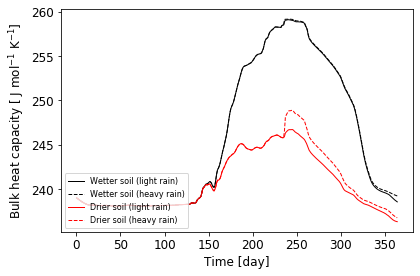

In [142]:
Plot_HeatCapacity()